# Bounds

First we need some imports.

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import torchist
import swyft

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [41]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.on_after_forward = swyft.to_numpy32
        self.z_sampler = swyft.RectBoundSampler(stats.norm([0], [1]), bounds = bounds.params[0,0] if bounds else None)

    def forward(self, trace):
        z = trace.sample('z', self.z_sampler)
        x = trace.sample('x', lambda z: z + np.random.randn(1)*0.1, z)
        
sim = Simulator(bounds = bounds)

In [42]:
samples = sim.sample(10000)

100%|██████████| 10000/10000 [00:07<00:00, 1305.11it/s]


In [43]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__(lr = 1e-3, lrs_factor = 0.1, lrs_patience = 3, early_stopping_patience = 2)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [44]:
model_checkpoint = ModelCheckpoint(monitor = 'val_loss', save_top_k = 1)
logger = TensorBoardLogger("./lightning_logs", name = "Test1")
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 20, precision = 64, logger = logger, callbacks = [model_checkpoint])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [45]:
dl_train = samples[:-2000].get_dataloader(batch_size = 128, shuffle = True)
dl_valid = samples[-2000:].get_dataloader(batch_size = 128)

In [46]:
network = Network()

In [47]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 17.4 K
-----------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.139     Total estimated model params size (MB)


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 63/79 [00:00<00:00, 134.48it/s, loss=-0.63, v_num=45] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 63/79 [00:00<00:00, 113.45it/s, loss=-0.633, v_num=45, val_loss=-.580]
Validating: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 63/79 [00:00<00:00, 128.63it/s, loss=-0.596, v_num=45, val_loss=-.604]
Validating: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 63/79 [00:00<00:00, 107.24it/s, loss=-0.63, v_num=45, val_loss=-.608] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 63/79 [00:00<00:00, 131.85it/s, loss=-0.635, v_num=45, val_loss=-.600]
Validating: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 63/79 [00:00<00:00, 134.76it/s, loss=-0.635, v_num=45, val_loss=-.610]
Validating: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 63/79 [00:00<00:00, 118.00it/s, loss=-0.621, v_num=45, val_loss=-.608]
Validating: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 63/79 [00:00<00:00, 115.83it/s, loss=-0.613, v_num=45, val_loss=-.611]
Validating: 0it [00:00,

In [48]:
prior_samples = sim.sample(N = 10000, targets = ['z'])

100%|██████████| 10000/10000 [00:07<00:00, 1355.35it/s]


In [49]:
obs = swyft.Sample(x = np.array([0.3]))

In [50]:
logratios = trainer.infer(network, obs, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 63it [00:00, ?it/s]


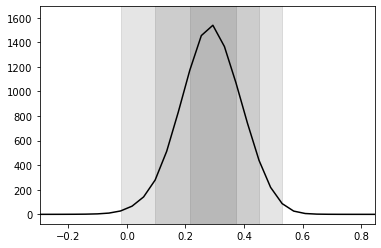

In [51]:
swyft.plot_1d(logratios, "z[0]", ax = plt.gca(), smooth = 1, bins = 30)

In [53]:
bounds = swyft.lightning.bounds.get_rect_bounds(logratios, threshold = 1e-4)
bounds

RectangleBounds(params=tensor([[[-0.2306,  0.7157]]], dtype=torch.float64), parnames=array([['z[0]']], dtype='<U4'))